In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =6.5e-24

nband = 1100

ng =6

ng_refs = (/ 3 , 3 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 1900

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.8/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.7,
     &     0.7 , 0.8/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

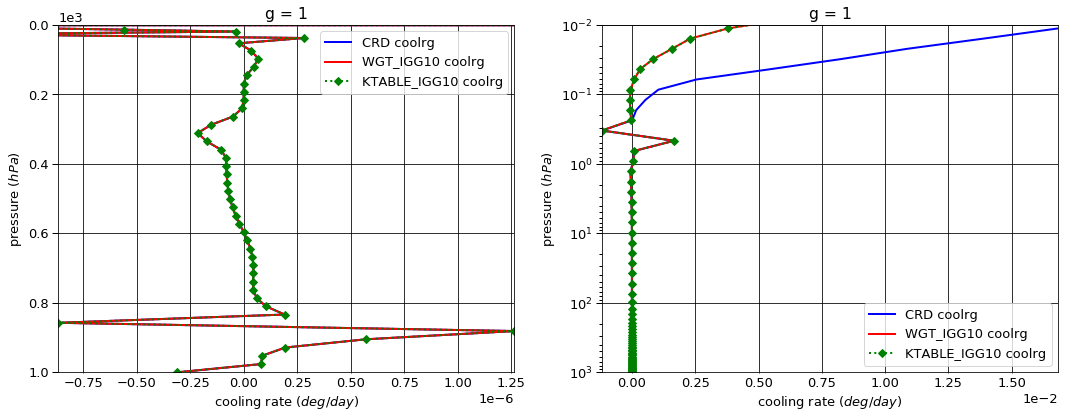

# Figure: cooling rate g-group 2

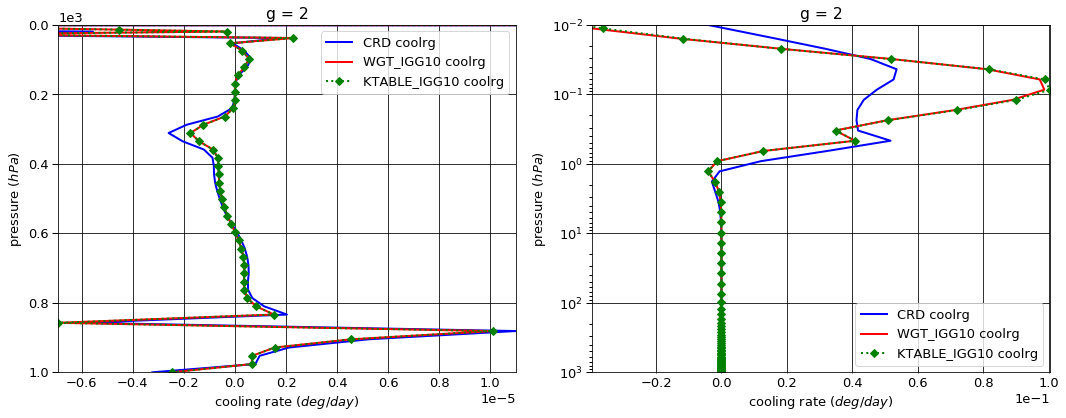

# Figure: cooling rate g-group 3

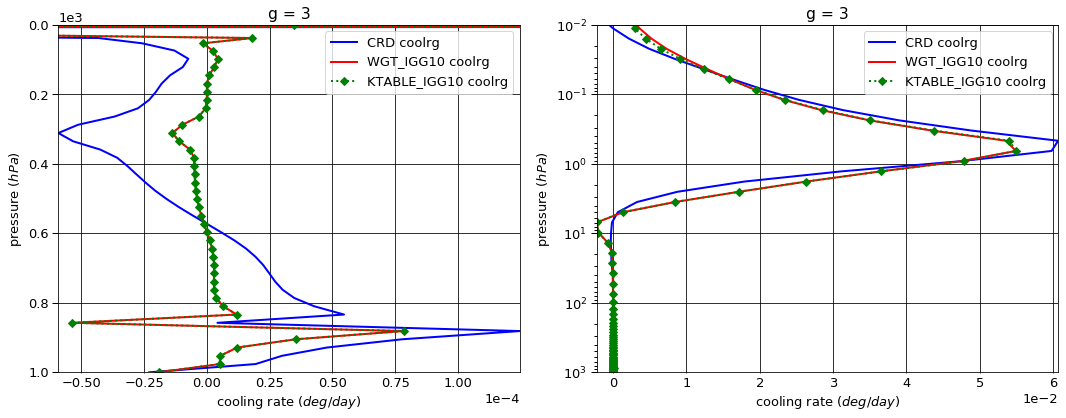

# Figure: cooling rate g-group 4

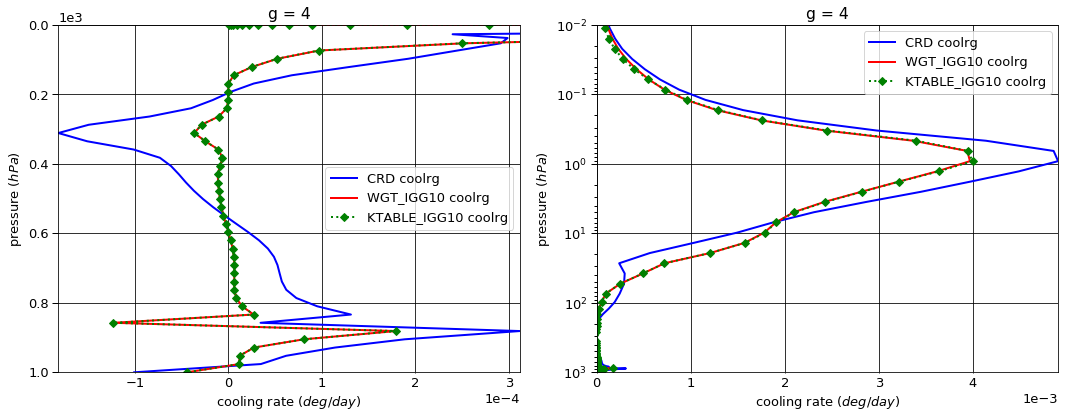

# Figure: cooling rate g-group 5

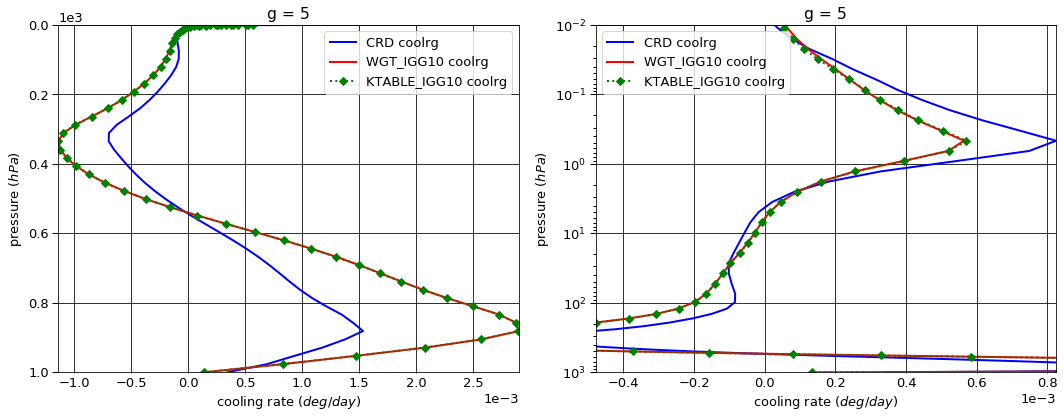

# Figure: cooling rate g-group 6

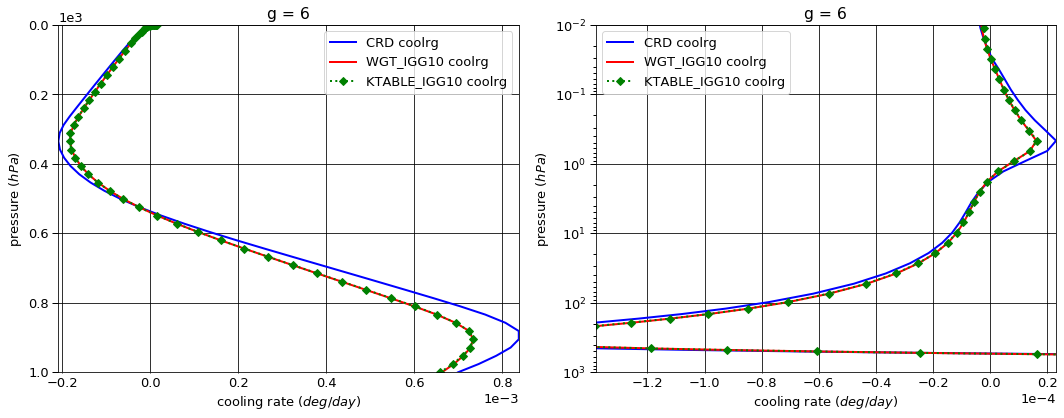

# Figure: cooling rate g-group total

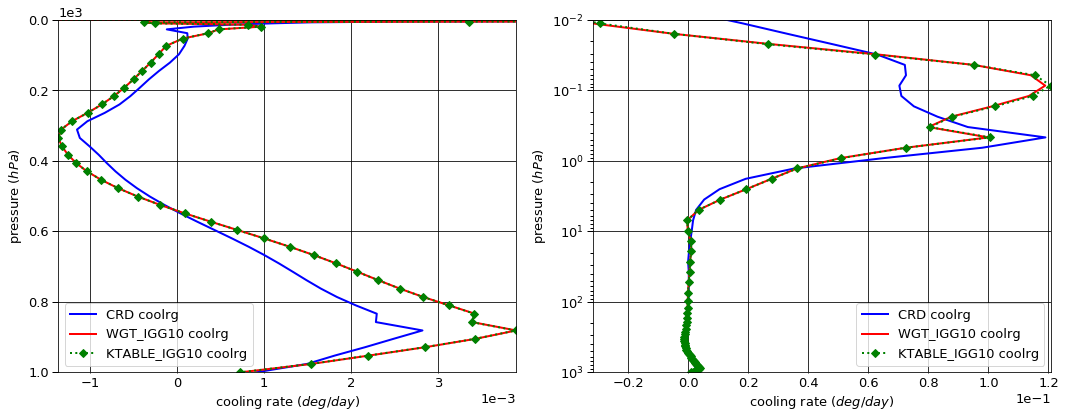

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000084  0.000000 -0.000084
  1013.0   76    -0.000604  0.000605  0.000001
2 0.0      1     -0.003384  0.000000 -0.003384
  1013.0   76    -0.004853  0.004864  0.000011
3 0.0      1     -0.009970  0.000000 -0.009970
  1013.0   76    -0.037986  0.037418 -0.000568
4 0.0      1     -0.008234  0.000000 -0.008234
  1013.0   76    -0.087266  0.087308  0.000041
5 0.0      1     -0.090172  0.000000 -0.090172
  1013.0   76    -0.164792  0.099609 -0.065183
6 0.0      1     -1.155958  0.000000 -1.155958
  1013.0   76    -1.171409  0.037217 -1.134192


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000040  0.000000 -0.000040
  1013.0   76    -0.000604  0.000605  0.000001
2 0.0      1     -0.003053  0.000000 -0.003053
  1013.0   76    -0.004853  0.004861  0.000008
3 0.0      1     -0.010463  0.000000 -0.010463
  1013.0   76    -0.037986  0.038050  0.000065
4 0.0      1     -0.007379  0.000000 -0.007379
  1013.0   76    -0.087266  0.087415  0.000148
5 0.0      1     -0.049118  0.000000 -0.049118
  1013.0   76    -0.164792  0.167628  0.002836
6 0.0      1     -1.158645  0.000000 -1.158645
  1013.0   76    -1.171409  0.031491 -1.139918


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000040  0.000000 -0.000040
  1013.0   76    -0.000604  0.000605  0.000001
2 0.0      1     -0.003086  0.000000 -0.003086
  1013.0   76    -0.004853  0.004861  0.000008
3 0.0      1     -0.010484  0.000000 -0.010484
  1013.0   76    -0.037986  0.038050  0.000065
4 0.0      1     -0.007383  0.000000 -0.007383
  1013.0   76    -0.087266  0.087415  0.000148
5 0.0      1     -0.048975  0.000000 -0.048975
  1013.0   76    -0.164792  0.167651  0.002860
6 0.0      1     -1.158599  0.000000 -1.158599
  1013.0   76    -1.171409  0.031517 -1.139892


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000044  0.000000  0.000044
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.000331  0.000000  0.000331
  1013.0   76     0.000000 -0.000003 -0.000003
3 0.0      1     -0.000494  0.000000 -0.000494
  1013.0   76     0.000000  0.000633  0.000633
4 0.0      1      0.000856  0.000000  0.000856
  1013.0   76     0.000000  0.000107  0.000107
5 0.0      1      0.041054  0.000000  0.041054
  1013.0   76     0.000000  0.068019  0.068019
6 0.0      1     -0.002687  0.000000 -0.002687
  1013.0   76     0.000000 -0.005726 -0.005726


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000044  0.000000  0.000044
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.000298  0.000000  0.000298
  1013.0   76     0.000000 -0.000003 -0.000003
3 0.0      1     -0.000514  0.000000 -0.000514
  1013.0   76     0.000000  0.000633  0.000633
4 0.0      1      0.000852  0.000000  0.000852
  1013.0   76     0.000000  0.000107  0.000107
5 0.0      1      0.041197  0.000000  0.041197
  1013.0   76     0.000000  0.068043  0.068043
6 0.0      1     -0.002641  0.000000 -0.002641
  1013.0   76     0.000000 -0.005700 -0.005700

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      9.236936e-02
  1001.112500 75    -3.095410e-07
2 0.000312    1     -8.923998e-02
  1001.112500 75    -3.232388e-06
3 0.000312    1     -5.508342e-03
  1001.112500 75    -2.299027e-05
4 0.000312    1     -1.270851e-06
  1001.112500 75    -1.006192e-04
5 0.000312    1     -8.019417e-05
  1001.112500 75     3.409792e-04
6 0.000312    1     -5.549970e-06
  1001.112500 75     6.992251e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.747259e-01
  1001.112500 75    -3.095410e-07
2 0.000312    1     -1.316592e-01
  1001.112500 75    -2.471333e-06
3 0.000312    1     -1.266243e-03
  1001.112500 75    -1.917491e-05
4 0.000312    1      4.768604e-06
  1001.112500 75    -4.394360e-05
5 0.000312    1     -2.080017e-05
  1001.112500 75     1.374273e-04
6 0.000312    1     -4.546187e-06
  1001.112500 75     6.625899e-04


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.748647e-01
  1001.112500 75    -3.095410e-07
2 0.000312    1     -1.191548e-01
  1001.112500 75    -2.471333e-06
3 0.000312    1     -9.352981e-04
  1001.112500 75    -1.917491e-05
4 0.000312    1      9.775336e-07
  1001.112500 75    -4.394360e-05
5 0.000312    1     -1.782803e-05
  1001.112500 75     1.345235e-04
6 0.000312    1     -3.647176e-06
  1001.112500 75     6.588791e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      8.235651e-02
  1001.112500 75    -5.293956e-23
2 0.000312    1     -4.241919e-02
  1001.112500 75     7.610550e-07
3 0.000312    1      4.242099e-03
  1001.112500 75     3.815359e-06
4 0.000312    1      6.039455e-06
  1001.112500 75     5.667563e-05
5 0.000312    1      5.939400e-05
  1001.112500 75    -2.035519e-04
6 0.000312    1      1.003782e-06
  1001.112500 75    -3.663512e-05


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      8.249537e-02
  1001.112500 75    -5.293956e-23
2 0.000312    1     -2.991483e-02
  1001.112500 75     7.610550e-07
3 0.000312    1      4.573044e-03
  1001.112500 75     3.815359e-06
4 0.000312    1      2.248385e-06
  1001.112500 75     5.667563e-05
5 0.000312    1      6.236614e-05
  1001.112500 75    -2.064557e-04
6 0.000312    1      1.902794e-06
  1001.112500 75    -4.034591e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.267802,0.000000,-1.267802
1013.0,76,-1.466909,0.267019,-1.199890



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.228698,0.000000,-1.228698
1013.0,76,-1.466909,0.330049,-1.136860



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.228566,0.000000,-1.228566
1013.0,76,-1.466909,0.330099,-1.136810



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.039103,0.00000,0.039103
1013.0,76,0.000000,0.06303,0.063030



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.039235,0.00000,0.039235
1013.0,76,0.000000,0.06308,0.063080


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.002466
1001.112500,75,0.000913



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.041780
1001.112500,75,0.000734



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.054754
1001.112500,75,0.000728



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.044246
1001.112500,75,-0.000179



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.057220
1001.112500,75,-0.000186


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000568,0.000397
2,0.004291,0.003203
3,0.032091,0.025151
4,0.071123,0.057827
5,0.076623,0.112104
6,0.815305,0.801318


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,9.493630e-18
2,1.027587e-19
3,1.112255e-21
4,6.007831e-22
5,6.500239e-24
6,3.693103e-32


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,9.493630e-18,NaN,0.000568,0.000397,0.000568,0.000397,1.0
2,1.027587e-19,1.082396e-02,0.004291,0.003203,0.004859,0.003600,1.0
3,1.112255e-21,1.082396e-02,0.032091,0.025151,0.036950,0.028751,1.0
4,6.007831e-22,5.401485e-01,0.071123,0.057827,0.108073,0.086578,50.0
5,6.500239e-24,1.081961e-02,0.076623,0.112104,0.184695,0.198682,50.0
6,3.693103e-32,5.681487e-09,0.815305,0.801318,1.000000,1.000000,50.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog         ratio        taulyr
layer g pressure                                                           
1     1 0.000312     1.607997e-16  1.407863e-17  1.142155e+01  6.181905e-01
      2 0.000312     6.029178e-19  8.117883e-20  7.427032e+00  2.362988e-03
      3 0.000312     2.451442e-21  3.859642e-22  6.351477e+00  9.696588e-06
      4 0.000312     1.270385e-23  1.042456e-23  1.218646e+00  6.362797e-08
      5 0.000312     1.000589e-23  8.952744e-25  1.117634e+01  3.849793e-08
      6 0.000312     4.545081e-26  8.518135e-32  5.335769e+05  1.924744e-10
2     1 0.000750     1.606484e-16  1.426936e-17  1.125828e+01  2.488950e-01
      2 0.000750     6.105861e-19  8.242236e-20  7.408015e+00  9.640206e-04
      3 0.000750     2.500116e-21  3.934296e-22  6.354671e+00  3.983077e-06
      4 0.000750     1.318192e-23  1.083486e-23  1.216620e+00  2.660445e-08
      5 0.000750     1.017350e-23  9.084535e-25  1.119870e+01  1.576503e-08
      6 0.000750     4.641542e-26  1.064673e-31  4.359592e+05  7.917148e-11
3     1 0.001052     1.603469e-16  1.466120e-17  1.093683e+01  3.487673e-01
      2 0.001052     6.266684e-19  8.483854e-20  7.386600e+00  1.387757e-03
      3 0.001052     2.601274e-21  4.046324e-22  6.428734e+00  5.807590e-06
      4 0.001052     1.408214e-23  1.158211e-23  1.215853e+00  3.986423e-08
      5 0.001052     1.052982e-23  9.347649e-25  1.126468e+01  2.287807e-08
      6 0.001052     4.848837e-26  1.172075e-31  4.136967e+05  1.159876e-10
4     1 0.001476     1.600447e-16  1.506858e-17  1.062109e+01  4.889081e-01
      2 0.001476     6.439692e-19  8.736918e-20  7.370669e+00  2.000859e-03
      3 0.001476     2.713366e-21  4.170860e-22  6.505531e+00  8.492233e-06
      4 0.001476     1.511479e-23  1.243442e-23  1.215560e+00  6.002997e-08
      5 0.001476     1.091809e-23  9.624298e-25  1.134430e+01  3.327037e-08
      6 0.001476     5.077858e-26  1.289350e-31  3.938308e+05  1.704036e-10
5     1 0.002070     1.597454e-16  1.548664e-17  1.031505e+01  6.852411e-01
      2 0.002070     6.623407e-19  9.000019e-20  7.359325e+00  2.886685e-03
      3 0.002070     2.836211e-21  4.309985e-22  6.580559e+00  1.244159e-05
      4 0.002070     1.629343e-23  1.340189e-23  1.215756e+00  9.075911e-08
      5 0.002070     1.133637e-23  9.912010e-25  1.143700e+01  4.843801e-08
      6 0.002070     5.327980e-26  1.394298e-31  3.821265e+05  2.507787e-10
6     1 0.002904     1.594485e-16  1.591536e-17  1.001853e+01  9.605600e-01
      2 0.002904     6.818344e-19  9.273650e-20  7.352385e+00  4.168655e-03
      3 0.002904     2.971009e-21  4.467698e-22  6.649979e+00  1.827008e-05
      4 0.002904     1.764808e-23  1.450803e-23  1.216435e+00  1.378759e-07
      5 0.002904     1.178732e-23  1.021185e-24  1.154279e+01  7.062528e-08
      6 0.002904     5.601290e-26  1.482246e-31  3.778920e+05  3.698218e-10
7     1 0.004074     1.591318e-16  1.635346e-17  9.730773e+00  1.346403e+00
      2 0.004074     7.024112e-19  9.558828e-20  7.348299e+00  6.024338e-03
      3 0.004074     3.118772e-21  4.649359e-22  6.707962e+00  2.688934e-05
      4 0.004074     1.921491e-23  1.578198e-23  1.217522e+00  2.105309e-07
      5 0.004074     1.227231e-23  1.052511e-24  1.166003e+01  1.031104e-07
      6 0.004074     5.899308e-26  1.550539e-31  3.804683e+05  5.463779e-10
8     1 0.005714     1.587704e-16  1.679936e-17  9.450981e+00  1.886637e+00
      2 0.005714     7.240190e-19  9.857620e-20  7.344765e+00  8.710398e-03
      3 0.005714     3.280707e-21  4.862109e-22  6.747499e+00  3.966156e-05
      4 0.005714     2.104098e-23  1.726240e-23  1.218891e+00  3.232773e-07
      5 0.005714     1.279270e-23  1.085394e-24  1.178622e+01  1.507065e-07
      6 0.005714     6.223615e-26  1.599378e-31  3.891273e+05  8.085250e-10
9     1 0.008015     1.584097e-16  1.725581e-17  9.180082e+00  2.643782e+00
      2 0.008015     7.469259e-19  1.017513e-19  7.340700e+00  1.260515e-02
      3 0.008015     3.459807e-21  5.115869e-22  6.762893e+00  5.866303e-0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
